In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-18 15:46:36 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'
2025-02-18 15:46:36 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-02-18 15:46:36 __main__ INFO     transformers.__version__='4.48.1'


In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B',
 'Llama-3.1-8B-Instruct',
 'Llama-2-7b-chat-hf',
 'Llama-3.2-3B-Instruct',
 'Llama-3.2-3B',
 'Llama-3.2-1B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-02-18 15:46:37 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

2025-02-18 15:46:43 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")


# entities = coincidences["examples"][0]["entity_pair"]
# entities = ("Whale", "Dolphin")
# entities = ("Nautilus", "Dolphin")
# entities = ("Abraham Lincoln", "John F. Kennedy")
# entities = ("Brad Pitt", "Angelina Jolie")
# entities = ("Emu", "Ostrich")
# entities = ("Elephant", "Whale")
# entities = ("Wolverine", "Penguin")
# entities = ("Giraffe", "Reindeer")
entities = ("Hydrogen", "Oxygen")

print(entities)

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

2025-02-18 15:46:43 __main__ INFO     len(coincidences['examples'])=20


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


('Hydrogen', 'Oxygen')
<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Hydrogen and Oxygen
A: They are/were both

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


answer='elements in the periodic table.'


In [6]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

('Hydrogen', 'Oxygen')


[[PredictedToken(token=' elements', prob=0.2198486328125, logit=16.5, token_id=5540),
  PredictedToken(token=' gases', prob=0.1397705078125, logit=16.046875, token_id=45612),
  PredictedToken(token=' used', prob=0.09381103515625, logit=15.6484375, token_id=1511),
  PredictedToken(token=' g', prob=0.0560302734375, logit=15.1328125, token_id=342),
  PredictedToken(token=' chemical', prob=0.045379638671875, logit=14.921875, token_id=11742)]]

In [7]:
single_probing_prompt = "Who/what is {}? Answer: {} is a"

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = [single_probing_prompt.format(entities[0], entities[0])],
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{5540: (1228, PredictedToken(token=' elements', prob=1.2278556823730469e-05, logit=7.08984375, token_id=5540))}]


[[PredictedToken(token=' chemical', prob=0.267578125, logit=17.078125, token_id=11742),
  PredictedToken(token=' color', prob=0.1409912109375, logit=16.4375, token_id=1933),
  PredictedToken(token=' gas', prob=0.11505126953125, logit=16.234375, token_id=6962),
  PredictedToken(token=' non', prob=0.03564453125, logit=15.0625, token_id=2536),
  PredictedToken(token=' simple', prob=0.0273284912109375, logit=14.796875, token_id=4382),
  PredictedToken(token=' very', prob=0.0219573974609375, logit=14.578125, token_id=1633),
  PredictedToken(token=' light', prob=0.018341064453125, logit=14.3984375, token_id=3177),
  PredictedToken(token=' colour', prob=0.017364501953125, logit=14.34375, token_id=12745),
  PredictedToken(token=' natural', prob=0.01406097412109375, logit=14.1328125, token_id=5933),
  PredictedToken(token=' g', prob=0.01342010498046875, logit=14.0859375, token_id=342),
  PredictedToken(token=' naturally', prob=0.0131072998046875, logit=14.0625, token_id=18182),
  PredictedToken

In [8]:
pred, track_ans = predict_next_token(
    mt = mt,
    inputs = single_probing_prompt.format(entities[1], entities[1]),
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{5540: (6549, PredictedToken(token=' elements', prob=6.616115570068359e-06, logit=3.3125, token_id=5540))}]


[[PredictedToken(token=' gas', prob=0.0278472900390625, logit=11.65625, token_id=6962),
  PredictedToken(token=' non', prob=0.0253448486328125, logit=11.5625, token_id=2536),
  PredictedToken(token=' free', prob=0.019287109375, logit=11.2890625, token_id=1949),
  PredictedToken(token=' chemical', prob=0.019134521484375, logit=11.28125, token_id=11742),
  PredictedToken(token=' company', prob=0.01513671875, logit=11.046875, token_id=2883),
  PredictedToken(token=' ', prob=0.0126495361328125, logit=10.8671875, token_id=220),
  PredictedToken(token=' brand', prob=0.012451171875, logit=10.8515625, token_id=6883),
  PredictedToken(token=' group', prob=0.01187896728515625, logit=10.8046875, token_id=1912),
  PredictedToken(token=' new', prob=0.010650634765625, logit=10.6953125, token_id=502),
  PredictedToken(token=' magazine', prob=0.00829315185546875, logit=10.4453125, token_id=14756),
  PredictedToken(token=' nonprofit', prob=0.0081024169921875, logit=10.421875, token_id=33184),
  Predict

In [9]:
prompt.entity_ranges

((206, 208), (209, 210))

In [10]:
import types
from tqdm.auto import tqdm
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token, get_module_nnsight, interpret_logits
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
from src.utils.typing import PredictedToken

def get_edges_to_be_ablated(
    prompt: ProbingPrompt,
    focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all",
    Q_IDX: int = -1, # almost always the last token position
    whitelist_key_indices: list[int] = [0, -1]
):
    for idx, ti in enumerate(whitelist_key_indices):
        if ti < 0:
            whitelist_key_indices[idx] = prompt.tokenized["input_ids"][0].shape[-1] + ti
    
    if focus_strategy == "entities":
        whitelist_key_indices += list(range(*prompt.entity_ranges[0])) + list(range(*prompt.entity_ranges[1]))
    elif focus_strategy == "entities_last":
        whitelist_key_indices += [prompt.entity_ranges[0][1] - 1, prompt.entity_ranges[1][1] - 1]
    elif focus_strategy == "ablate_all":
        pass
    else:
        raise ValueError(f"{focus_strategy=}")
    
    whitelist_key_indices = list(set(whitelist_key_indices))
    
    block_edges: list[AttentionEdge] = []
    for k_idx in range(1, prompt.tokenized["input_ids"][0].shape[-1]):
        if k_idx in whitelist_key_indices:
            continue
        block_edges.append(
            AttentionEdge(
                q_idx=Q_IDX,
                k_idx=k_idx,
            )
        )
    
    return block_edges

    

@torch.inference_mode()
def attn_blocking_sweep_cumulative(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    direction: Literal["asc", "desc"] = "asc",
    step: int = 1,
    verbose: bool = False
):
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()
    
    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    effects = {}

    if direction == "asc":
        progress = tqdm(range(0, mt.n_layer, step))
    elif direction == "desc":
        progress = tqdm(range(mt.n_layer - 1, -1, -step))

    progress.set_description(f"{direction=}")

    for layer_idx in progress:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        # attn_block = get_module_nnsight(mt, attn_block_name)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

        ablated_pred, track_ans = predict_next_token(
            mt=mt, 
            inputs=inputs,
            token_of_interest=[clean_answer.token_id]
        )
        # output = mt._model(**inputs)
        # logits = output.logits[:, -1, :].squeeze()
        # ablated_pred, track_ans = interpret_logits(tokenizer=mt, logits=logits, interested_tokens=[answer.token_id])

        if verbose:
            logger.debug(f"{layer_idx}: {track_ans=}")

        effects[layer_idx] = {
            "track_ans": track_ans,
            "ablated_pred": ablated_pred,
        }
    

    mt.reset_forward()
    return effects

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy="entities",
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

blocking_effects = attn_blocking_sweep_cumulative(
    mt=mt, prompt=prompt,
    block_edges=block_edges,
    clean_answer=clean_pred[0][0],
    direction="desc",
)

direction='desc':   0%|          | 0/32 [00:00<?, ?it/s]

direction='desc': 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


In [13]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy=focus_strategy,
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

effects_asc = attn_blocking_sweep_cumulative(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    direction="asc",
)
effects_desc = attn_blocking_sweep_cumulative(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    direction="desc",
)    

100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


In [15]:
clean_pred[0][0]

PredictedToken(token=' elements', prob=0.2198486328125, logit=16.5, token_id=5540)

2025-02-18 13:43:46 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-02-18 13:43:46 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2025-02-18 13:43:46 matplotlib DEBUG    interactive is False
2025-02-18 13:43:46 matplotlib DEBUG    platform is linux
2025-02-18 13:43:46 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2025-02-18 13:43:46 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2025-02-18 13:43:46 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-18 13:43:46 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-18 13:43:46 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-02-18 13:43:46 

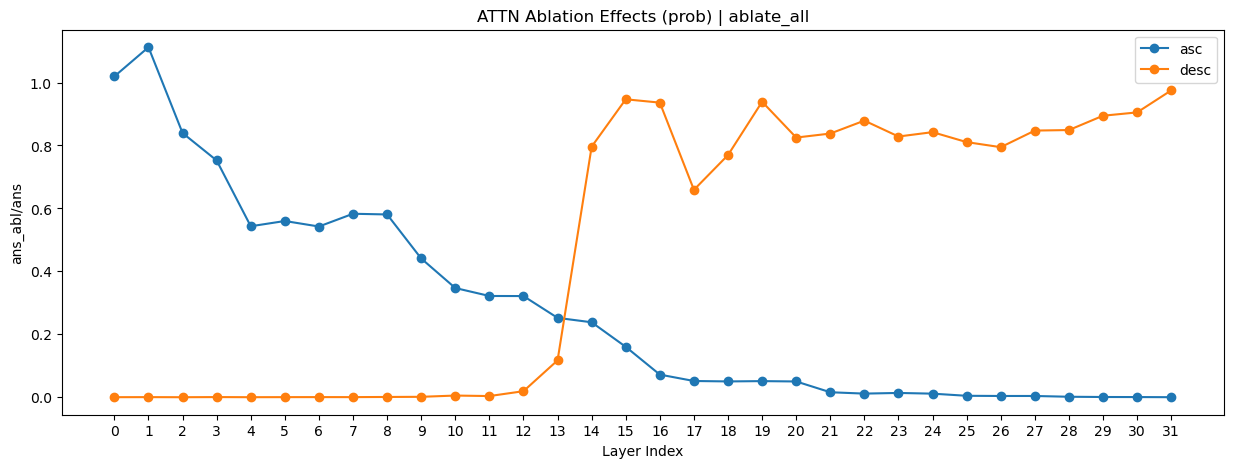

In [16]:
import matplotlib.pyplot as plt

metric = "prob"

denom = getattr(clean_pred[0][0], metric)

layers = list(range(mt.n_layer))
values_asc = []
for layer_idx in layers:
    track_ans = list(effects_asc[layer_idx]["track_ans"][0].values())[0][1]
    values_asc.append(getattr(track_ans, metric) / denom)

values_desc = []
for layer_idx in layers:
    track_ans = list(effects_desc[layer_idx]["track_ans"][0].values())[0][1]
    values_desc.append(getattr(track_ans, metric) / denom)


plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation Effects ({metric}) | {focus_strategy}")

plt.plot(values_asc, marker="o", label="asc")
plt.plot(values_desc, marker="o", label="desc")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

In [11]:
@torch.inference_mode()
def ablate_attn_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    layer_window: tuple[int, int],
):
    
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    for layer_idx in layer_window:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

    ablated_pred, track_ans = predict_next_token(
        mt=mt, 
        inputs=inputs,
        token_of_interest=[clean_answer.token_id]
    )

    mt.reset_forward()

    return ablated_pred, track_ans

In [13]:
focus_strategy = "ablate_all"
# layer_window = list(range(0, 5))
# layer_window = list(range(0, mt.n_layer))
layer_window = list(range(10, 20))

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy=focus_strategy,
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

track_ans = ablate_attn_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=layer_window,
)

track_ans

([[PredictedToken(token=' elements', prob=0.08001708984375, logit=13.0625, token_id=5540),
   PredictedToken(token=' used', prob=0.07635498046875, logit=13.015625, token_id=1511),
   PredictedToken(token=' gases', prob=0.05853271484375, logit=12.75, token_id=45612),
   PredictedToken(token=' in', prob=0.048919677734375, logit=12.5703125, token_id=304),
   PredictedToken(token=' gas', prob=0.02679443359375, logit=11.96875, token_id=6962)]],
 [{5540: (1,
    PredictedToken(token=' elements', prob=0.08001708984375, logit=13.0625, token_id=5540))}])

In [14]:
from src.trace import get_window

def attn_blocking_sweep_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    window_size: int,
):
    effects = {}

    for layer_idx in tqdm(range(mt.n_layer), desc=f"{window_size=}"):
        layer_window = get_window("{}", layer_idx, window_size, mt.n_layer)
        layer_window = [int(l) for l in layer_window]
        ablated_pred, track_ans = ablate_attn_window(
            mt=mt,
            prompt=prompt,
            clean_answer=clean_answer,
            block_edges=block_edges,
            layer_window=layer_window,
        )
        effects[layer_idx] = dict(
            track_ans=track_ans,
            ablated_pred=ablated_pred,
        )
    return effects  

window_ablation_effects = attn_blocking_sweep_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    window_size=5,
)

window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


In [26]:
window_ablation_effects

{0: {'track_ans': [{5540: (1609,
     PredictedToken(token=' elements', prob=2.205371856689453e-06, logit=6.08984375, token_id=5540))}],
  'ablated_pred': [[PredictedToken(token=' explor', prob=0.452392578125, logit=18.328125, token_id=48539),
    PredictedToken(token=' famous', prob=0.129638671875, logit=17.078125, token_id=11495),
    PredictedToken(token=' Portuguese', prob=0.06939697265625, logit=16.453125, token_id=43288),
    PredictedToken(token=' sailors', prob=0.059326171875, logit=16.296875, token_id=69938),
    PredictedToken(token=' European', prob=0.038604736328125, logit=15.8671875, token_id=7665)]]},
 1: {'track_ans': [{5540: (1583,
     PredictedToken(token=' elements', prob=2.4437904357910156e-06, logit=6.10546875, token_id=5540))}],
  'ablated_pred': [[PredictedToken(token=' explor', prob=0.459716796875, logit=18.25, token_id=48539),
    PredictedToken(token=' famous', prob=0.11444091796875, logit=16.859375, token_id=11495),
    PredictedToken(token=' Portuguese', pro

2025-02-18 14:35:12 matplotlib.legend WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


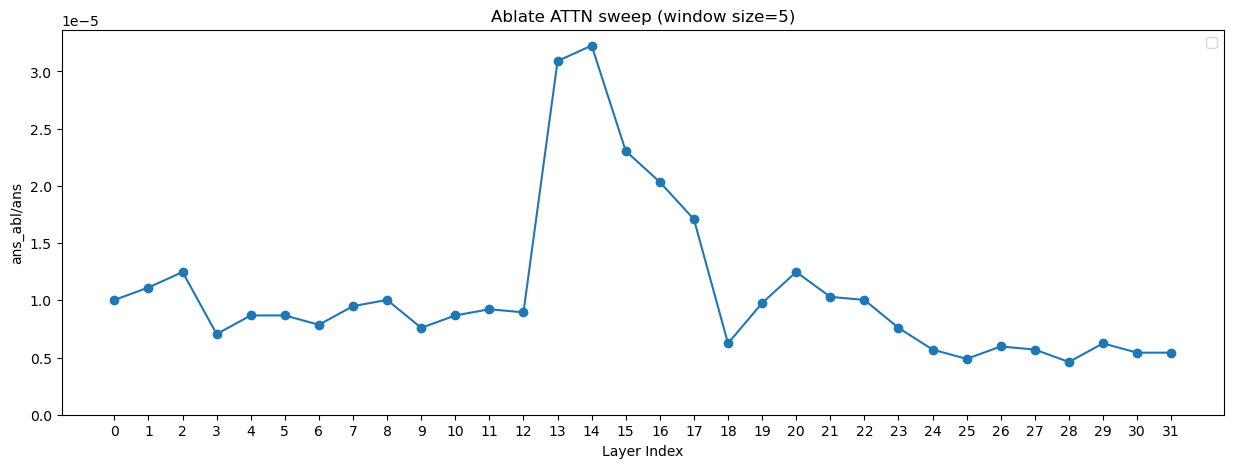

In [27]:
from matplotlib import pyplot as plt

metric = "prob"
denom = getattr(clean_pred[0][0], metric)

values = []
layers = list(range(mt.n_layer))
for layer_idx in layers:
    track_ans = list(window_ablation_effects[layer_idx]["track_ans"][0].values())[0][1]
    values.append(getattr(track_ans, metric) / denom)


plt.figure(figsize=(15, 5))
plt.plot(values, marker="o")
plt.xticks(layers)

plt.title(f"Ablate ATTN sweep (window size={5})")
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.ylim(bottom=0)  
plt.legend()

In [12]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-18 15:47:49 __main__ INFO     len(coincidences['examples'])=20


In [ ]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "entities"

effects = []

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    prompt = prepare_probing_input(
        mt=mt,
        entities=entities,
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both"
    )

    clean_answer = predict_next_token(mt=mt, inputs = TokenizerOutput(data = prompt.tokenized), k=1)[0][0]
    logger.info(f"{clean_answer=}")

    block_edges = get_edges_to_be_ablated(
        prompt=prompt,
        focus_strategy=focus_strategy,
        Q_IDX=-1,
        whitelist_key_indices=[0]
        # whitelist_key_indices=[0, -1]
    )

    cumulative_effects_asc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="asc",
    )

    cumulative_effects_desc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="desc",
    )

    attn_ablation_effects = attn_blocking_sweep_window(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        window_size=5,
    )


    effects.append(dict(
        entities=entities,
        clean_answer=clean_answer,
        attn_ablation_effects=attn_ablation_effects,
        cumulative_effects=dict(
            asc=cumulative_effects_asc,
            desc=cumulative_effects_desc
        )
    ))

    print("-" * 80)

2025-02-18 16:30:59 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


2025-02-18 16:31:00 __main__ INFO     clean_answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)


direction='desc':  56%|█████▋    | 18/32 [00:13<00:14,  1.05s/it]

In [16]:
def get_metric_value(track_ans):
    rank, pred = list(track_ans[0].values())[0]
    if metric in ["prob", "logit"]:
        return getattr(pred, metric)
    elif metric == "reciprocal_rank":
        return 1 / rank

from src.utils.metrics import AggregateMetric
from typing import Optional
def process_effects_per_layer(
    effects: list[dict],
    metric: Literal["logit", "prob", "reciprocal_rank"] = "prob",
    v_clean_ans: Optional[list[float]] = None
):
    if v_clean_ans is not None:
        assert metric in ["logit", "prob"]
        assert len(v_clean_ans) == len(effects)

    layer_wise_results: dict[int, AggregateMetric] = {}
    layer_indices = list(range(mt.n_layer))
    for layer_idx in layer_indices:
        values = []
        for idx, e in enumerate(effects):
            track_ans = e[int(layer_idx)]["track_ans"]
            v = get_metric_value(track_ans)
            if v_clean_ans is not None:
                v /= v_clean_ans[idx]
            values.append(v)
        layer_wise_results[layer_idx] = AggregateMetric.aggregate(values)
    return layer_wise_results


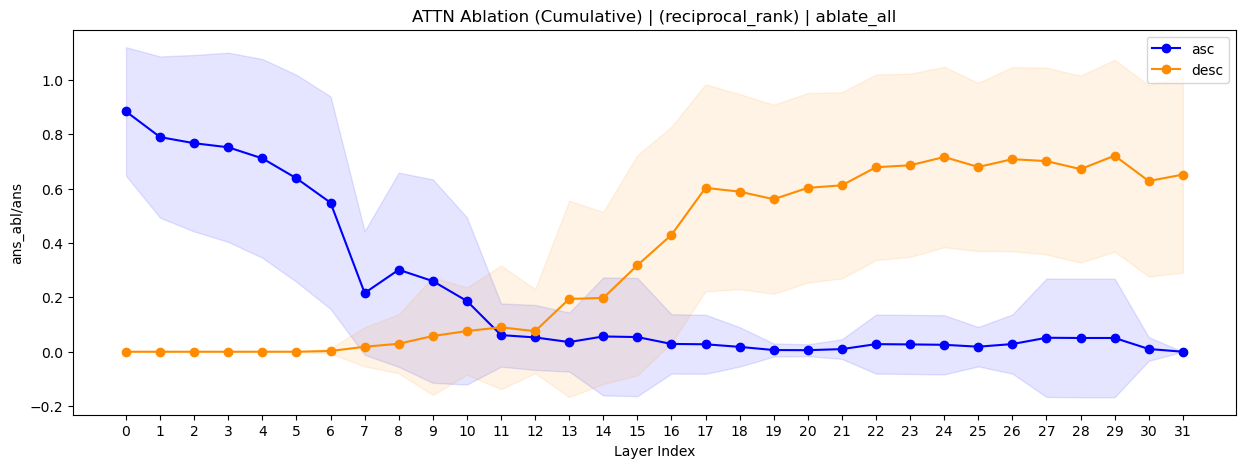

In [25]:
from matplotlib import pyplot as plt

metric: Literal["logit", "prob", "reciprocal_rank"] = "reciprocal_rank"

effects_asc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["asc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)


effects_desc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["desc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

def plot_metric(results: dict[int, AggregateMetric], keys: list, label: str, color:str, canvas=plt):
    values = [results[k].mean for k in keys]
    stds = [results[k].stdev for k in keys]
    canvas.plot(values, marker="o", label=label, color=color)
    canvas.fill_between(keys, [v - s for v, s in zip(values, stds)], [v + s for v, s in zip(values, stds)], alpha=0.1, color=color)


plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (Cumulative) | ({metric}) | {focus_strategy}")

layers = list(range(mt.n_layer))
plot_metric(effects_asc, layers, "asc", color="blue")
plot_metric(effects_desc, layers, "desc", color="darkorange")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

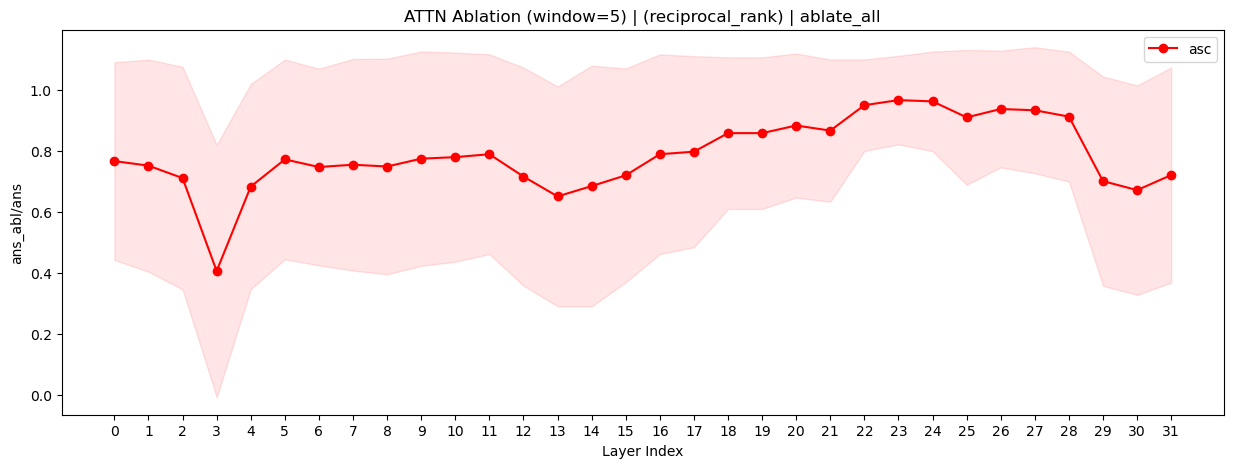

In [26]:
effects_window = process_effects_per_layer(
    effects=[e["attn_ablation_effects"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (window=5) | ({metric}) | {focus_strategy}")

plot_metric(effects_window, list(effects_asc.keys()), "asc", color="red")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()